STEP 1: IMPORT NECESSARY LIBRARIES

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, cv2, random
import tensorflow as tf
from tqdm import tqdm
import kagglehub
from keras import Model, layers, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay




In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/ML/Image

/content/gdrive/MyDrive/ML/Image


In [4]:
ls

10.jpg  4.jpg   8.jpg                 convnet.keras           training_loss.png
1.jpg   5.jpg   9.jpg                 cover.jpg
2.jpg   6.jpeg  confusion_matrix.png  sample_predictions.png
3.jpg   7.jpg   convnet_best.keras    training_accuracy.png


STEP 2: DOWNLOAD DATASET

In [5]:
dataset_path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print(f"✓ Dataset downloaded to: {dataset_path}\n")

Using Colab cache for faster access to the 'face-mask-12k-images-dataset' dataset.
✓ Dataset downloaded to: /kaggle/input/face-mask-12k-images-dataset



STEP 3: DEFINE CONSTANTS

In [6]:
IMG_SIZE = 128  # Size to which each image will be resized (128x128 pixels)
CATEGORIES = ["WithMask", "WithoutMask"]  # Labels for classification
BATCH_SIZE = 64  # Number of images to process at once during training

print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Categories: {CATEGORIES}")
print(f"Batch Size: {BATCH_SIZE}")
print("✓ Constants defined\n")

Image Size: 128x128
Categories: ['WithMask', 'WithoutMask']
Batch Size: 64
✓ Constants defined



STEP 4: LOAD AND PREPROCESS DATA

In [7]:
def load_data(data_dir):
    """
    Loads images from the specified directory, preprocesses them by
    converting to grayscale, resizing to IMG_SIZE, and normalizing pixel values.

    Parameters:
        data_dir (str): Path to the directory containing the dataset.

    Returns:
        X (numpy.ndarray): Array of preprocessed images.
        y (numpy.ndarray): Array of corresponding labels (0 for 'WithMask', 1 for 'WithoutMask').
    """
    training_data = []  # Initialize an empty list to hold data

    # Search for the actual Face Mask Dataset folder
    if 'Face Mask Dataset' in os.listdir(data_dir):
        data_dir = os.path.join(data_dir, 'Face Mask Dataset')

    print(f"\nSearching in: {data_dir}")

    # Look for Train/Test/Validation folders
    for split in ['Train', 'Test', 'Validation']:
        split_path = os.path.join(data_dir, split)
        if os.path.exists(split_path):
            print(f"Found {split} folder")
            data_dir = split_path
            break

    category_paths = {}

    # Now look for WithMask and WithoutMask folders
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            if 'withmask' in item.lower().replace(' ', ''):
                category_paths['WithMask'] = item_path
                print(f"  Found WithMask: {item}")
            elif 'withoutmask' in item.lower().replace(' ', '') or 'nomask' in item.lower().replace(' ', ''):
                category_paths['WithoutMask'] = item_path
                print(f"  Found WithoutMask: {item}")

    if len(category_paths) != 2:
        print(f"\nERROR: Found only {list(category_paths.keys())}")
        return None, None

    # Loop through each category ('WithMask' and 'WithoutMask')
    for category in CATEGORIES:
        if category not in category_paths:
            continue

        path = category_paths[category]
        class_num = CATEGORIES.index(category)  # Convert category name to numeric label

        image_files = [f for f in os.listdir(path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        # Iterate through all images in the category directory
        for img in tqdm(image_files, desc=f"Loading {category} images"):
            try:
                # Load image using OpenCV
                img_array = cv2.imread(os.path.join(path, img))

                if img_array is None:
                    continue

                # Convert the image to grayscale to reduce complexity
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                # Resize the image to the specified IMG_SIZE (128x128)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

                # Append the processed image and its label to the training_data list
                training_data.append([resized_array, class_num])

            except Exception as e:
                pass  # Skip any images that cannot be processed

    if len(training_data) == 0:
        print("ERROR: No images loaded!")
        return None, None

    # Shuffle the training data to mix images from both classes
    random.shuffle(training_data)

    # Extract features (images) and labels from the training data
    X = np.array([i[0] for i in training_data]).astype(np.float32) / 255.0  # Normalize pixel values
    y = np.array([i[1] for i in training_data])

    # Reshape X to include a single channel (grayscale)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

    print(f"Loaded {len(X)} images: {np.sum(y==0)} WithMask, {np.sum(y==1)} WithoutMask")

    return X, y

    # Loop through each category ('WithMask' and 'WithoutMask')
    for category in CATEGORIES:
        if category not in category_paths:
            continue

        path = category_paths[category]
        class_num = CATEGORIES.index(category)  # Convert category name to numeric label

        image_files = [f for f in os.listdir(path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        # Iterate through all images in the category directory
        for img in tqdm(image_files, desc=f"Loading {category} images"):
            try:
                # Load image using OpenCV
                img_array = cv2.imread(os.path.join(path, img))

                if img_array is None:
                    continue

                # Convert the image to grayscale to reduce complexity
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                # Resize the image to the specified IMG_SIZE (128x128)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

                # Append the processed image and its label to the training_data list
                training_data.append([resized_array, class_num])

            except Exception as e:
                pass  # Skip any images that cannot be processed

    # Shuffle the training data to mix images from both classes
    random.shuffle(training_data)

    # Extract features (images) and labels from the training data
    X = np.array([i[0] for i in training_data]).astype(np.float32) / 255.0  # Normalize pixel values
    y = np.array([i[1] for i in training_data])

    # Reshape X to include a single channel (grayscale)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

    return X, y

# Load datasets - Navigate to correct path structure
base_path = dataset_path

# The dataset has structure: Face Mask Dataset/Train|Test|Validation/WithMask|WithoutMask
face_mask_folder = os.path.join(base_path, 'Face Mask Dataset')

if os.path.exists(face_mask_folder):
    print(f"\nFound Face Mask Dataset folder")

    train_dir = os.path.join(face_mask_folder, 'Train')
    val_dir = os.path.join(face_mask_folder, 'Validation')
    test_dir = os.path.join(face_mask_folder, 'Test')

    print(f"\nLoading training data...")
    X_train, y_train = load_data(train_dir)

    if X_train is None:
        raise ValueError("Failed to load training data")

    print(f"\nLoading validation data...")
    X_val, y_val = load_data(val_dir)

    if X_val is None:
        raise ValueError("Failed to load validation data")

    print(f"\nLoading test data...")
    X_test, y_test = load_data(test_dir)

    if X_test is None:
        raise ValueError("Failed to load test data")

    print(f"\n✓ All data loaded successfully")
    print(f"  Training: {len(X_train)} images")
    print(f"  Validation: {len(X_val)} images")
    print(f"  Test: {len(X_test)} images\n")
else:
    raise ValueError(f"Could not find 'Face Mask Dataset' folder in {base_path}")


Found Face Mask Dataset folder

Loading training data...

Searching in: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train
  Found WithoutMask: WithoutMask
  Found WithMask: WithMask


Loading WithoutMask images: 100%|██████████| 5000/5000 [00:23<00:00, 209.52it/s]


Loaded 10000 images: 5000 WithMask, 5000 WithoutMask

Loading validation data...

Searching in: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation
  Found WithoutMask: WithoutMask
  Found WithMask: WithMask


Loading WithoutMask images: 100%|██████████| 400/400 [00:02<00:00, 158.31it/s]


Loaded 800 images: 400 WithMask, 400 WithoutMask

Loading test data...

Searching in: /kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test
  Found WithoutMask: WithoutMask
  Found WithMask: WithMask


Loading WithoutMask images: 100%|██████████| 509/509 [00:02<00:00, 170.09it/s]


Loaded 992 images: 483 WithMask, 509 WithoutMask

✓ All data loaded successfully
  Training: 10000 images
  Validation: 800 images
  Test: 992 images



STEP 5: DEFINE THE CNN MODEL

In [8]:
class ConvNet(Model):
    """
    Custom CNN model for face mask detection.
    Inherits from keras.Model and overrides the call method for forward pass.
    """

    def __init__(self):
        super(ConvNet, self).__init__()

        # First Convolutional Block: Conv2D -> MaxPooling2D
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.pool1 = layers.MaxPooling2D()

        # Second Convolutional Block: Conv2D -> MaxPooling2D
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.pool2 = layers.MaxPooling2D()

        # Third Convolutional Block: Conv2D -> MaxPooling2D
        self.conv3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.pool3 = layers.MaxPooling2D()

        # Fourth Convolutional Block: Conv2D -> MaxPooling2D
        self.conv4 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.pool4 = layers.MaxPooling2D()

        # Fifth Convolutional Block: Conv2D -> MaxPooling2D
        self.conv5 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')
        self.pool5 = layers.MaxPooling2D()

        # Flatten and Fully Connected Layer
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.3)  # Dropout for regularization
        self.classifier = layers.Dense(2, activation='softmax')  # Output layer for binary classification

    def call(self, x):
        """
        Forward pass of the model.
        """
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.flatten(x)
        x = self.dropout(x)
        return self.classifier(x)

print("✓ CNN model defined\n")

✓ CNN model defined



STEP 6: COMPILE THE MODEL

In [9]:
# Instantiate and compile the model
model = ConvNet()
optimizer = Adam(learning_rate=0.0001)  # Optimizer for training
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled with Adam optimizer")
print(f"  Learning rate: 0.0001")
print(f"  Loss function: sparse_categorical_crossentropy\n")

✓ Model compiled with Adam optimizer
  Learning rate: 0.0001
  Loss function: sparse_categorical_crossentropy



STEP 7: SETUP DATA AUGMENTATION

In [10]:
# Data augmentation pipeline to increase dataset diversity and reduce overfitting
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),      # Randomly flip images horizontally
    layers.RandomRotation(0.1),           # Randomly rotate images by 10%
    layers.RandomZoom(0.1),               # Randomly zoom into images
    layers.RandomBrightness(0.2),         # Adjust brightness randomly
    layers.RandomContrast(0.2)            # Adjust contrast randomly
])

print("✓ Data augmentation configured")
print("  - Random horizontal flip")
print("  - Random rotation (10%)")
print("  - Random zoom (10%)")
print("  - Random brightness adjustment (20%)")
print("  - Random contrast adjustment (20%)\n")

✓ Data augmentation configured
  - Random horizontal flip
  - Random rotation (10%)
  - Random zoom (10%)
  - Random brightness adjustment (20%)
  - Random contrast adjustment (20%)



STEP 8: SETUP CALLBACKS

In [11]:
# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min",
        verbose=1
    ),
    ModelCheckpoint(
        filepath="convnet_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1
    )
]

print("✓ Callbacks configured")
print("  - Early stopping (patience=5)")
print("  - Model checkpoint (save best val_accuracy)\n")

✓ Callbacks configured
  - Early stopping (patience=5)
  - Model checkpoint (save best val_accuracy)



STEP 9: TRAIN THE MODEL

In [12]:
# Training the model using the augmented data
history = model.fit(
    data_augmentation(X_train),  # Apply data augmentation to training data
    y_train,                     # Training labels
    validation_data=(X_val, y_val),  # Validation data for performance evaluation
    epochs=50,                   # Maximum number of epochs to train
    batch_size=BATCH_SIZE,       # Number of samples per batch
    callbacks=callbacks,         # Use callbacks to optimize training
    verbose=1
)

# Save the final model
model.save("convnet.keras")
print("\n✓ Training complete")
print("✓ Model saved as: convnet.keras\n")

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5091 - loss: 0.7001
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to convnet_best.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.5090 - loss: 0.7001 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4984 - loss: 0.6967
Epoch 2: val_accuracy did not improve from 0.50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4984 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6883
Epoch 3/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4974 - loss: 0.6944
Epoch 3: val_accuracy did not improve from 0.50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4975 - loss: 0.6944 - val_accuracy: 0.4975 - val_loss: 0.6643
Epoch 4/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5071 - loss: 0.6930
Epoch 4: val_accuracy did not improve from 0.50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.

STEP 10: VISUALIZE TRAINING HISTORY

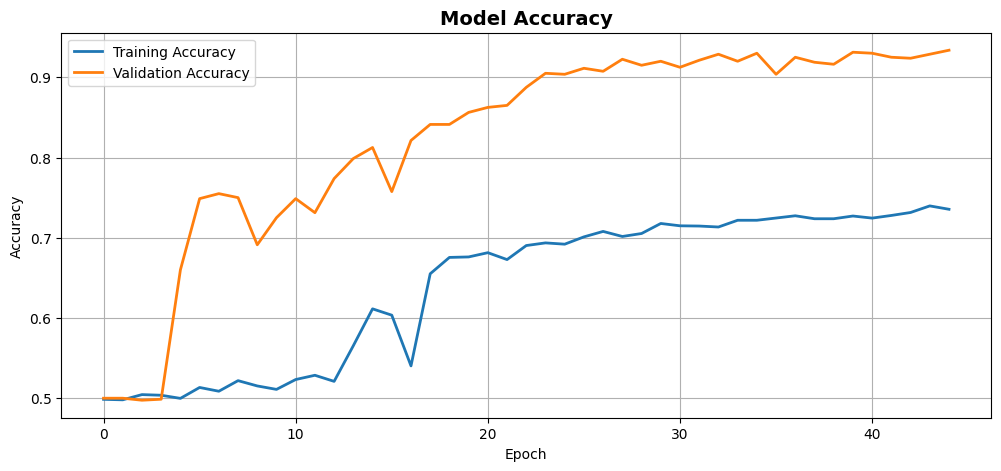

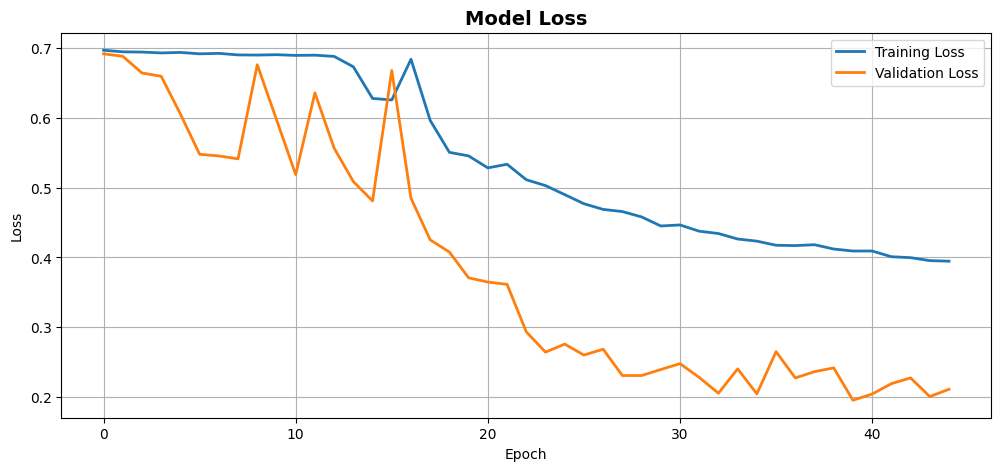

✓ Training history plots saved



In [13]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved\n")

STEP 11: LOAD BEST MODEL AND EVALUATE

In [14]:
# Use the model directly from training (already the best due to callbacks)
# No need to reload since EarlyStopping restores best weights automatically

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"\n{'='*70}")
print("TEST SET RESULTS")
print(f"{'='*70}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*70}\n")

31/31 - 0s - 7ms/step - accuracy: 0.9385 - loss: 0.2012

TEST SET RESULTS
Test Accuracy: 0.9385 (93.85%)
Test Loss: 0.2012



STEP 12: GENERATE PREDICTIONS

In [15]:
# Get predictions for the test set
# For a softmax output, use argmax to get the predicted class
y_pred = np.argmax(model.predict(X_test), axis=1)

print(f"✓ Generated predictions for {len(X_test)} test images\n")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✓ Generated predictions for 992 test images



STEP 13: CLASSIFICATION REPORT



In [16]:
# Print classification report
report = classification_report(y_test, y_pred, target_names=CATEGORIES, digits=4)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    WithMask     0.9567    0.9151    0.9354       483
 WithoutMask     0.9226    0.9607    0.9413       509

    accuracy                         0.9385       992
   macro avg     0.9397    0.9379    0.9384       992
weighted avg     0.9392    0.9385    0.9384       992



STEP 14: CONFUSION MATRIX

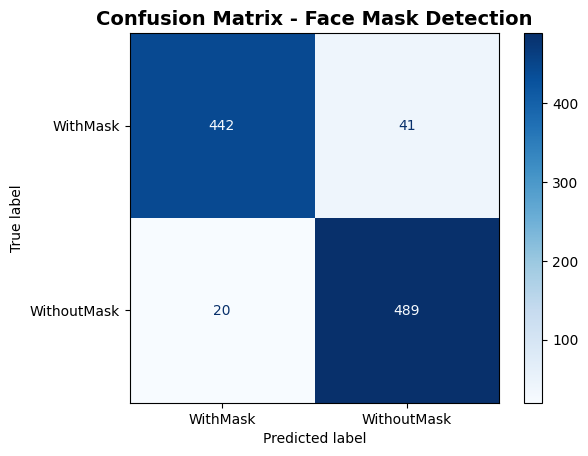

✓ Confusion matrix saved as: confusion_matrix.png



In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Face Mask Detection", fontsize=14, fontweight='bold')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as: confusion_matrix.png\n")

STEP 15: VISUALIZE SAMPLE PREDICTIONS



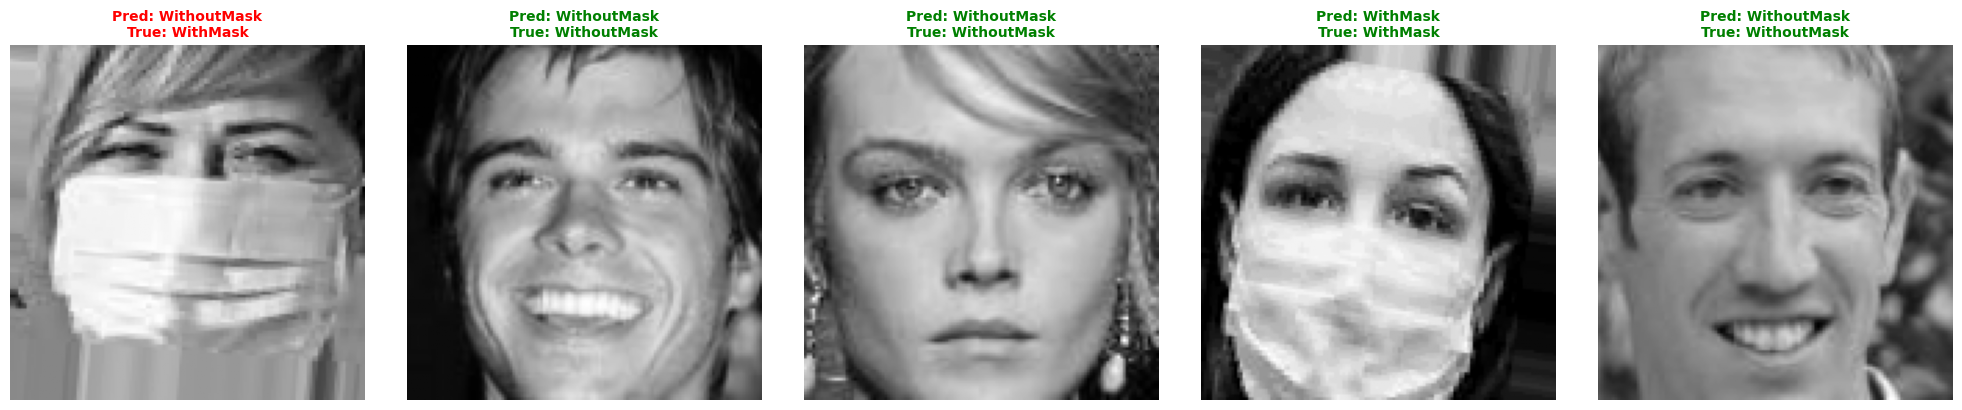

✓ Sample predictions saved as: sample_predictions.png



In [25]:
# Function to visualize test images with predictions
def plot_predictions(images, predictions, true_labels, class_names):
    num_samples = min(5, len(images))
    plt.figure(figsize=(20, 4))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")

        pred_label = class_names[predictions[i]]
        true_label = class_names[true_labels[i]]

        # Color: green for correct, red for incorrect
        color = 'green' if predictions[i] == true_labels[i] else 'red'

        plt.title(f"Pred: {pred_label}\nTrue: {true_label}",
                 color=color, fontweight='bold', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot predictions with true labels
plot_predictions(X_test, y_pred, y_test, CATEGORIES)

print("✓ Sample predictions saved as: sample_predictions.png\n")

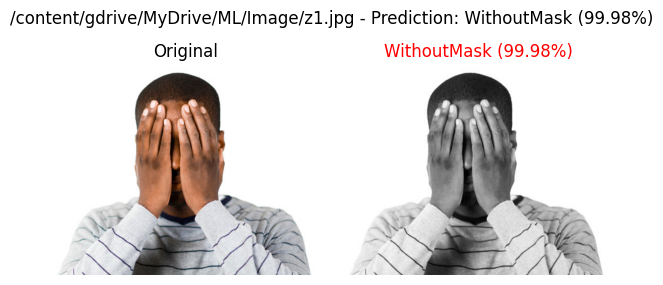

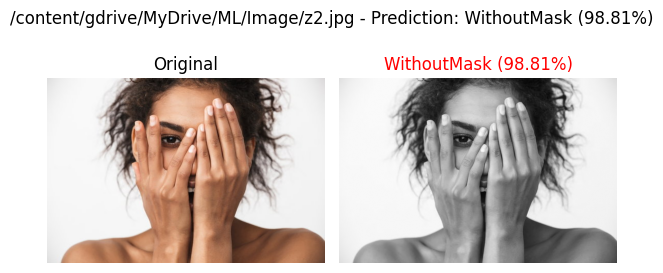

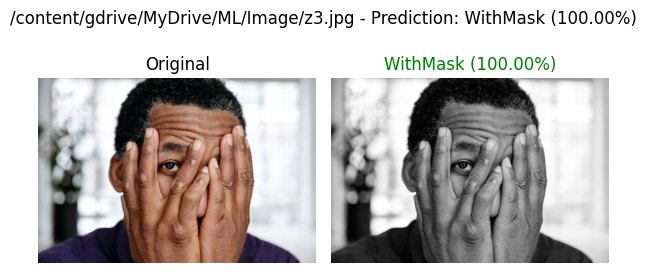

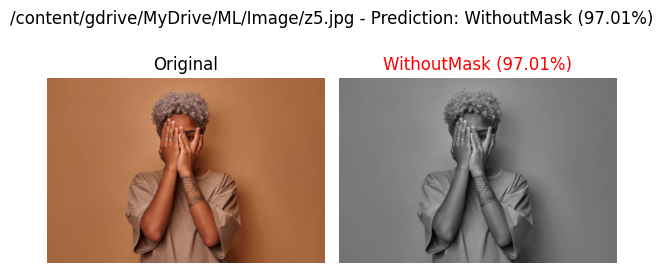

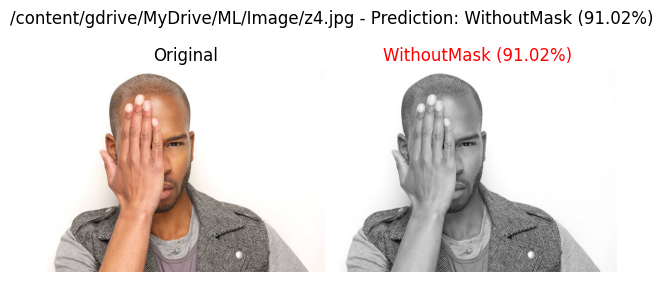

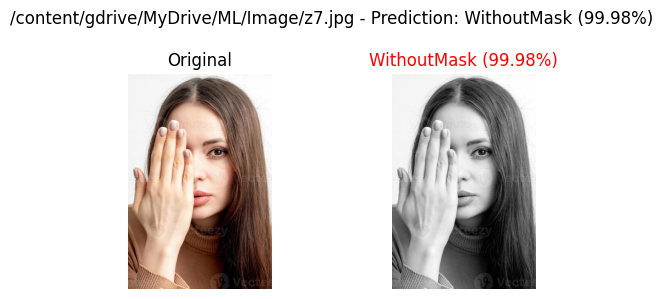

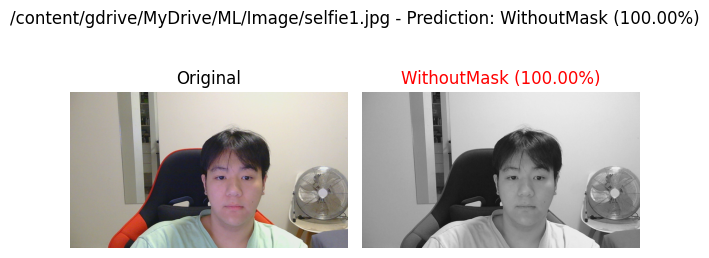

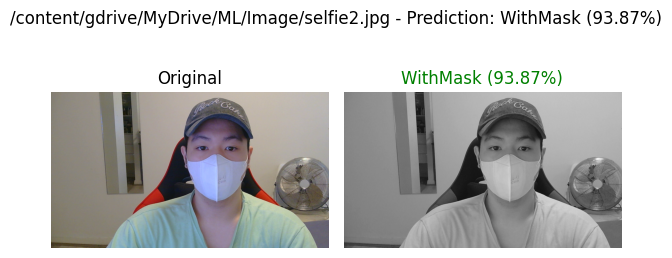

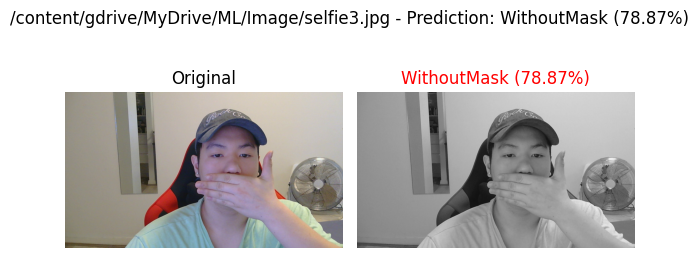

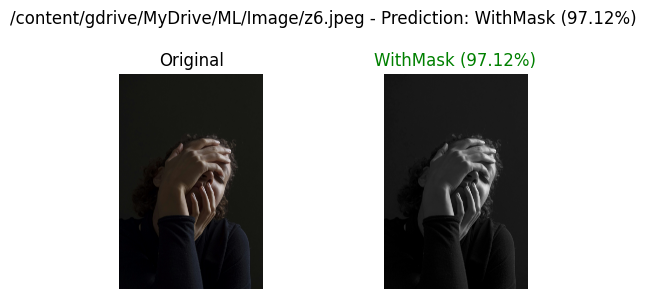

In [45]:
def predict_uploaded_images(model, categories, img_size=128):
    image_folder = "/content/gdrive/MyDrive/ML/Image"
    image_paths = (
        glob.glob(f"{image_folder}/*.jpg")
        + glob.glob(f"{image_folder}/*.jpeg")
    )

    for image_path in image_paths:
        if not os.path.exists(image_path):
            print(f"❌ File not found: {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"⚠️ Unable to load image: {image_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (img_size, img_size)) / 255.0
        input_img = resized.reshape(1, img_size, img_size, 1)

        pred = model.predict(input_img, verbose=0)[0]
        label = categories[np.argmax(pred)]
        conf = np.max(pred) * 100

        plt.figure(figsize=(6, 3))
        plt.suptitle(f"{image_path} - Prediction: {label} ({conf:.2f}%)", fontsize=12)

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gray, cmap='gray')
        plt.title(f"{label} ({conf:.2f}%)", color='green' if label == "WithMask" else 'red')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

predict_uploaded_images(model, CATEGORIES, img_size=IMG_SIZE)


FINAL SUMMARY


In [ ]:
print("TRAINING AND EVALUATION COMPLETE")
print("="*70)
print("\nGenerated Files:")
print("  1. convnet_best.keras          - Best model during training")
print("  2. convnet.keras               - Final trained model")
print("  3. training_accuracy.png       - Accuracy plot")
print("  4. training_loss.png           - Loss plot")
print("  5. confusion_matrix.png        - Confusion matrix")
print("  6. sample_predictions.png      - Sample predictions")

# Check if test results exist
try:
    print("\nModel Performance:")
    print(f"  - Test Accuracy: {final_test_accuracy:.4f} ({final_test_accuracy*100:.2f}%)")
    print(f"  - Test Loss: {final_test_loss:.4f}")
except NameError:
    print("\nModel Performance:")
    print(f"  - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  - Test Loss: {test_loss:.4f}")

print(f"  - Training Images: {len(X_train)}")
print(f"  - Validation Images: {len(X_val)}")
print(f"  - Test Images: {len(X_test)}")
print(f"  - Architecture: 5 Conv Blocks + Dropout + Softmax")
print("="*70)